In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

import keras
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from vit_keras import vit
from plotting import loss_accuracy_graph_from_pickle, loss_accuracy_graph, bar_accuracy_plot, scatter_plot
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.backend import clear_session


C:\Users\Rutger\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
data_path = r'C:\Users\User\Desktop\Master_Y1\Deep_learning\BrainTumorDetection-main\brain_tumor_dataset'
data_path2 = "brain_tumor_dataset"
classes = ['no', 'yes']
img_size = 224
def create_inception_v3():
    base_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    x = base_incep.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax')(x)
    inception = Model(inputs=base_incep.input, outputs=predictions)
    for layer in base_incep.layers:
        layer.trainable = False
    inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return inception

def create_resnet50():
    base_resn = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    x = base_resn.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax')(x)
    resnet = Model(inputs=base_resn.input, outputs=predictions)
    for layer in base_resn.layers:
        layer.trainable = False
    resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return resnet

def create_vgg16():
    base_model = keras.applications.VGG16(weights='imagenet', include_top=False) 
    base_model.trainable = False
    inputs = keras.Input((224, 224, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(2, activation='sigmoid')(x)
    VGG = keras.Model(inputs, outputs, name="VGG")
    VGG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return VGG

def create_vit_b16():
    b16 = vit.vit_b16(image_size=(img_size, img_size), activation='sigmoid', include_top=True, pretrained_top=False, classes=2)
    b16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return b16

def create_vit_b32():
    b32 = vit.vit_b32(image_size=(img_size, img_size), activation='sigmoid', include_top=True, pretrained_top=False, classes=2)
    b32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return b32

def create_vit_l16():
    l16 = vit.vit_l32(image_size=(64,64), activation='sigmoid', include_top=True, pretrained_top=False, classes=2)
    l16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return l16


In [16]:
def load_and_preprocess_data(img_size):
    #data_path = r'C:\Users\User\Desktop\Master_Y1\Deep_learning\BrainTumorDetection-main\brain_tumor_dataset'
    data_path = "brain_tumor_dataset"
    classes = ['no', 'yes']

    X = []
    Y = []
    for c in classes:
        path = os.path.join(data_path, c)
        class_num = classes.index(c)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_arr = cv2.resize(img_arr, (img_size, img_size))
            X.append(img_arr)
            Y.append(class_num)

    X = np.array(X)
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes=len(classes))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    return X, Y, kf

In [22]:
def cross_validate(create_model_fn, X, Y, kf, batch_size=8, epochs=10):
    val_accuracies = []
    val_losses = []

    best_history = None
    best_val_accuracy = -np.inf

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        clear_session()

        # Create a new instance of the model with reset weights
        model = create_model_fn()

        model_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

        # Save the validation accuracy and validation loss for this fold
        current_val_accuracy = model_history.history['val_binary_accuracy'][-1]
        
        val_accuracies.append(current_val_accuracy)
        val_losses.append(model_history.history['val_loss'][-1])

        # Check if the current fold has the highest validation accuracy
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            best_history = model_history
            
        del model
        del model_history
        del X_train
        del X_val
        del Y_train
        del Y_val
        gc.collect()

    # Calculate average validation accuracy and loss
    avg_val_accuracy = np.mean(val_accuracies)
    avg_val_loss = np.mean(val_losses)

    return avg_val_accuracy, avg_val_loss, best_history

In [23]:
img_size = 224
X, Y, kf = load_and_preprocess_data(img_size)

In [19]:
avg_val_accuracy, avg_val_loss, inception_history = cross_validate(create_inception_v3, X, Y, kf, batch_size=32, epochs=10)

Epoch 1/10
7/7 [==============================] - 14s 2s/step - loss: 32.1062 - binary_accuracy: 0.4851 - val_loss: 25.4854 - val_binary_accuracy: 0.6078
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 14.3870 - binary_accuracy: 0.6782 - val_loss: 10.1545 - val_binary_accuracy: 0.7059
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 5.9930 - binary_accuracy: 0.7475 - val_loss: 6.8355 - val_binary_accuracy: 0.7647
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 5.1285 - binary_accuracy: 0.7525 - val_loss: 3.6217 - val_binary_accuracy: 0.8431
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 2.4467 - binary_accuracy: 0.8069 - val_loss: 3.0983 - val_binary_accuracy: 0.8039
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 1.8154 - binary_accuracy: 0.8168 - val_loss: 3.0490 - val_binary_accuracy: 0.8039
Epoch 7/10
7/7 [==============================] - 11s 2s/step - loss: 1.6656 - binary_

In [7]:
file_path = "inception_history.pickle"

with open(file_path, 'wb') as file_pi:
    pickle.dump(inception_history.history, file_pi)

In [8]:
avg_val_accuracy, avg_val_loss, resnet_history = cross_validate(create_resnet50, X, Y, kf, batch_size=8, epochs=10)

Epoch 1/10
26/26 [==============================] - 6s 101ms/step - loss: 1.0125 - binary_accuracy: 0.7129 - val_loss: 0.3043 - val_binary_accuracy: 0.9020
Epoch 2/10
26/26 [==============================] - 1s 55ms/step - loss: 0.3163 - binary_accuracy: 0.8861 - val_loss: 0.5466 - val_binary_accuracy: 0.8235
Epoch 3/10
26/26 [==============================] - 1s 56ms/step - loss: 0.2475 - binary_accuracy: 0.9010 - val_loss: 0.3414 - val_binary_accuracy: 0.9020
Epoch 4/10
26/26 [==============================] - 1s 55ms/step - loss: 0.1317 - binary_accuracy: 0.9406 - val_loss: 0.3173 - val_binary_accuracy: 0.9020
Epoch 5/10
26/26 [==============================] - 1s 56ms/step - loss: 0.1125 - binary_accuracy: 0.9505 - val_loss: 0.3028 - val_binary_accuracy: 0.9020
Epoch 6/10
26/26 [==============================] - 1s 56ms/step - loss: 0.0671 - binary_accuracy: 0.9851 - val_loss: 0.3915 - val_binary_accuracy: 0.9020
Epoch 7/10
26/26 [==============================] - 1s 55ms/step - lo

In [9]:
file_path = "resnet_history.pickle"

with open(file_path, 'wb') as file_pi:
    pickle.dump(resnet_history.history, file_pi)

In [10]:
avg_val_accuracy, avg_val_loss, vgg16_history = cross_validate(create_vgg16, X, Y, kf, batch_size=8, epochs=10)

Epoch 1/10
26/26 [==============================] - 7s 183ms/step - loss: 2.1009 - binary_accuracy: 0.4728 - val_loss: 1.4663 - val_binary_accuracy: 0.5098
Epoch 2/10
26/26 [==============================] - 2s 70ms/step - loss: 1.1587 - binary_accuracy: 0.5866 - val_loss: 0.9411 - val_binary_accuracy: 0.5588
Epoch 3/10
26/26 [==============================] - 2s 70ms/step - loss: 0.8223 - binary_accuracy: 0.6485 - val_loss: 0.7633 - val_binary_accuracy: 0.6176
Epoch 4/10
26/26 [==============================] - 2s 70ms/step - loss: 0.6378 - binary_accuracy: 0.7030 - val_loss: 0.6009 - val_binary_accuracy: 0.7059
Epoch 5/10
26/26 [==============================] - 2s 70ms/step - loss: 0.5865 - binary_accuracy: 0.7376 - val_loss: 0.5618 - val_binary_accuracy: 0.7059
Epoch 6/10
26/26 [==============================] - 2s 71ms/step - loss: 0.4382 - binary_accuracy: 0.8045 - val_loss: 0.4893 - val_binary_accuracy: 0.7745
Epoch 7/10
26/26 [==============================] - 2s 71ms/step - lo

In [11]:
file_path = "vgg16_history.pickle"

with open(file_path, 'wb') as file_pi:
    pickle.dump(vgg16_history.history, file_pi)

In [12]:
avg_val_accuracy, avg_val_loss, b16_history = cross_validate(create_vit_b16, X, Y, kf, batch_size=8, epochs=10)

C:\Users\User\anaconda3\envs\GPU3\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/10
26/26 [==============================] - 28s 493ms/step - loss: 0.9043 - binary_accuracy: 0.5817 - val_loss: 0.6666 - val_binary_accuracy: 0.6176
Epoch 2/10
26/26 [==============================] - 9s 357ms/step - loss: 0.6865 - binary_accuracy: 0.6040 - val_loss: 0.5928 - val_binary_accuracy: 0.7647
Epoch 3/10
26/26 [==============================] - 9s 354ms/step - loss: 0.6266 - binary_accuracy: 0.6807 - val_loss: 0.5569 - val_binary_accuracy: 0.7255
Epoch 4/10
26/26 [==============================] - 10s 369ms/step - loss: 0.6153 - binary_accuracy: 0.6436 - val_loss: 0.5822 - val_binary_accuracy: 0.6569
Epoch 5/10
26/26 [==============================] - 9s 359ms/step - loss: 0.6038 - binary_accuracy: 0.7005 - val_loss: 0.5198 - val_binary_accuracy: 0.7255
Epoch 6/10
26/26 [==============================] - 10s 374ms/step - loss: 0.5120 - binary_accuracy: 0.7673 - val_loss: 0.5460 - val_binary_accuracy: 0.7157
Epoch 7/10
26/26 [==============================] - 9s 342ms/

In [13]:
file_path = "b16_history.pickle"

with open(file_path, 'wb') as file_pi:
    pickle.dump(b16_history.history, file_pi)

In [20]:
avg_val_accuracy, avg_val_loss, b32_history = cross_validate(create_vit_b32, X, Y, kf, batch_size=8, epochs=10)

C:\Users\Rutger\AppData\Local\Programs\Python\Python310\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/10
19/26 [====================>.........] - ETA: 18s - loss: 0.9671 - binary_accuracy: 0.5954

KeyboardInterrupt: 

In [15]:
file_path = "b32_history.pickle"

with open(file_path, 'wb') as file_pi:
    pickle.dump(b32_history.history, file_pi)

In [ ]:
# del X
# del Y
# del kf

img_size = 64
X, Y, kf = load_and_preprocess_data(img_size)

In [ ]:
avg_val_accuracy, avg_val_loss, l16_history = cross_validate(create_vit_l16, X, Y, kf, batch_size=2, epochs=2)

In [ ]:
file_path = "l16_history.pickle"

with open(file_path, 'wb') as file_pi:
    pickle.dump(l16_history.history, file_pi)

In [3]:
#load data in format

model_histories = {}
model_dict = {}
model_names = ['b32', 'b16', 'vgg16', 'resnet', 'inception'] #l16 is ignored for now
model_dict["b32"] = create_vit_b32()
model_dict["b16"] = create_vit_b16()
model_dict["vgg16"] = create_vgg16()
model_dict["resnet"] = create_resnet50()
model_dict["inception"] = create_inception_v3()


for model_name in model_names:
    file_path = f"{model_name}_history.pickle"
    with open(file_path, 'rb') as file_pi:
        model_histories[model_name] = pickle.load(file_pi)

C:\Users\Rutger\AppData\Local\Programs\Python\Python310\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(
C:\Users\Rutger\AppData\Local\Programs\Python\Python310\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


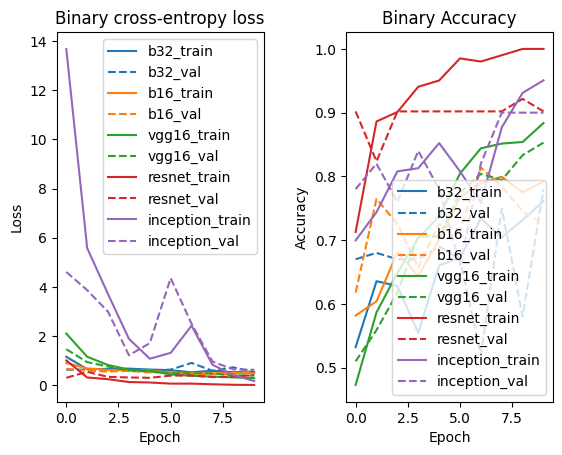

In [21]:
from tensorflow.python.keras.models import load_model
#start plotting

#loss_accuracy_graph(model_histories)
# loss_accuracy_graph_from_pickle(model_histories)
with open(file_path, 'rb') as file_pi:
        model_histories[model_name] = pickle.load(file_pi)

vitb16 = load_model("vit_b16.h5")

vitb32 = load_model("vit_b32.h5")


inception = create_inception_v3()
inc_acc, inc_los, inc_his = cross_validate(create_inception_v3, X, Y, kf, batch_size=32, epochs=10)

resnet = create_resnet50()
res_acc, res_los, res_his = cross_validate(create_resnet50, X, Y, kf, batch_size=32, epochs=10)

vgg = create_vgg16()
vgg_acc, vgg_los, vgg_his = cross_validate(create_vgg16, X, Y, kf, batch_size=32, epochs=10)








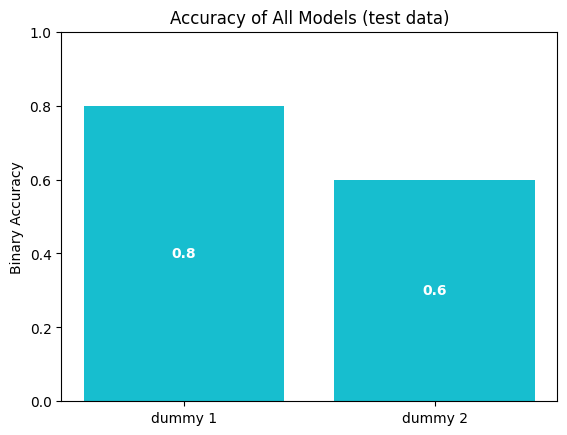

In [4]:
#
result_dict = {}
#result_dict["resnet"] = resnet.evaluate(x_test, y_test)
result_dict["dummy 1"] = [0.8, 0.8]
result_dict["dummy 2"] = [0.6, 0.6]

bar_accuracy_plot(result_dict)

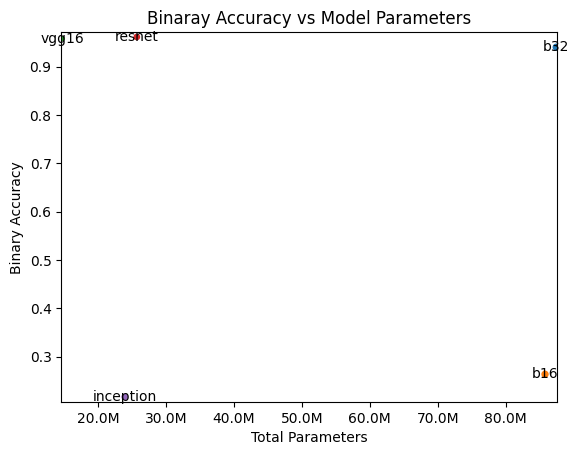

In [6]:
result_dict = {}
for name in model_names:
    result_dict[name] = np.random.random(2)
    


scatter_plot(model_dict, result_dict)

In [7]:
base_model = keras.applications.VGG16(weights='imagenet', include_top=True) 
base_model.trainable = False
inputs = keras.Input((224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation='sigmoid')(x)
VGG = keras.Model(inputs, outputs, name="VGG")
VGG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

VGG.summary()

ValueError: Input 0 of layer "global_average_pooling2d_4" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1000)